In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**All import**



In [19]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime, time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.models import Model
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

**Read all Data**

In [20]:
file_path = 'drive/My Drive/Protocol'
files = glob.glob(file_path+"/*.dat")
print(files)

['drive/My Drive/Protocol/subject101.dat', 'drive/My Drive/Protocol/subject102.dat', 'drive/My Drive/Protocol/subject103.dat', 'drive/My Drive/Protocol/subject104.dat', 'drive/My Drive/Protocol/subject105.dat', 'drive/My Drive/Protocol/subject106.dat', 'drive/My Drive/Protocol/subject107.dat', 'drive/My Drive/Protocol/subject108.dat', 'drive/My Drive/Protocol/subject109.dat']


**Create columns for the dataset**

In [21]:
header_name = ['timestamp','activityID','heart rate','IMU hand temperature','IMU hand AD','IMU hand scale 16','IMU hand resolution'
,'IMU hand AD2','IMU hand scale 6','IMU hand resolution *','IMU hand gyro1','IMU hand gyro2','IMU hand gyro3',
'IMU hand mag1', 'IMU hand mag2', 'IMU hand mag3','IMU hand orientation1', 'IMU hand orientation2','IMU hand orientation3','IMU hand orientation4',
'IMU chest temperature','IMU chest AD','IMU chest scale 16','IMU chest resolution'
,'IMU chest AD2','IMU chest scale 6','IMU chest resolution *','IMU chest gyro1','IMU chest gyro2','IMU chest gyro3',
'IMU chest mag1', 'IMU chest mag2', 'IMU chest mag3','IMU chest orientation1', 'IMU chest orientation2','IMU chest orientation3','IMU chest orientation4',
'IMU ankle temperature','IMU ankle AD','IMU ankle scale 16','IMU ankle resolution'
,'IMU ankle AD2','IMU ankle scale 6','IMU ankle resolution *','IMU ankle gyro1','IMU ankle gyro2','IMU ankle gyro3',
'IMU ankle mag1', 'IMU ankle mag2', 'IMU ankle mag3','IMU ankle orientation1', 'IMU ankle orientation2','IMU ankle orientation3','IMU ankle orientation4']


naive_columns=['heart rate','IMU hand temperature','IMU hand gyro1','IMU hand gyro2','IMU hand gyro3',
'IMU hand mag1', 'IMU hand mag2', 'IMU hand mag3',
'IMU chest temperature','IMU chest gyro1','IMU chest gyro2','IMU chest gyro3',
'IMU chest mag1', 'IMU chest mag2', 'IMU chest mag3',
'IMU ankle temperature','IMU ankle gyro1','IMU ankle gyro2','IMU ankle gyro3',
'IMU ankle mag1', 'IMU ankle mag2', 'IMU ankle mag3']

For fill NaN values, we get any subject and do partition per activity and fill all NaN by average in every column. 
There are missing sensory data due to wireless data dropping: missing values are indicated with NaN. 
Since data is given every 0.01s (due to the fact, that the IMUs have a sampling frequency of 100Hz), and the sampling frequency of the HR-monitor was only approximately 9Hz, the missing HR-values are also indicated with NaN in the data-files.

In [22]:
def fillNanValues(df):
  data_mean = df.groupby(['activityID']).mean()
  dic = {}
  data = pd.DataFrame(columns = df.columns)
  for i in (df['activityID'].unique()):
    dic[i] = df[df['activityID'] == i]
  for k,v in dic.items():
    data_check = pd.DataFrame(data=v, columns=df.columns)
    for column in data_check.columns:
      if(column == 'timestamp' or column == 'activityID'):
          continue
      data_check[column]=data_check[column].fillna(data_mean.loc[k,column])
    data = data.append(data_check)  
  return data

Read all data files and creat all partition dataset we using later - first we analyzed only the protocol (25 differnt activities)

In [23]:
all_data=pd.DataFrame(columns=header_name)
df_train = pd.DataFrame(columns=header_name)
df_test = pd.DataFrame(columns=header_name)
choosen_activities = [1, 2, 3]
for file in files:
  df = pd.DataFrame(columns=header_name)
  df_all_acitivities = pd.read_csv(file,sep=" ", names=header_name)
  for activity in choosen_activities:
    temp = df_all_acitivities[df_all_acitivities['activityID']== activity]
    df = df.append(temp,ignore_index=True)
  if(df.shape[0] == 0):
    continue  
  df= fillNanValues(df)
  df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
  if(file == 'drive/My Drive/Protocol/subject107.dat'):
      df_test = df_test.append(df,ignore_index=True)
  elif(file == 'drive/My Drive/Protocol/subject101.dat' or file == 'drive/My Drive/Protocol/subject102.dat' or file == 'drive/My Drive/Protocol/subject103.dat' ):
      df_train = df_train.append(df,ignore_index=True)  
  print(file)
  all_data = all_data.append(df,ignore_index=True)

drive/My Drive/Protocol/subject101.dat
drive/My Drive/Protocol/subject102.dat
drive/My Drive/Protocol/subject103.dat
drive/My Drive/Protocol/subject104.dat
drive/My Drive/Protocol/subject105.dat
drive/My Drive/Protocol/subject106.dat
drive/My Drive/Protocol/subject107.dat
drive/My Drive/Protocol/subject108.dat


Get some details on datasets: train, test

In [24]:
print("train data: {0}".format(df_train.shape))
print("test_data: {0}".format(df_test.shape)) 

train data: (215073, 54)
test_data: (63644, 54)


In [25]:
all_data.shape[0]

567642

Data contain 2872533 sampels. Each of them are mesurment collect among 8 hours from 3 sensors located in diffent places: 1 IMU over the wrist on the dominant arm,1 IMU on the chest, 1 IMU on the dominant side's ankle.

Data Frame

In [26]:
df_train.head()

,timestamp,activityID,heart rate,IMU hand temperature,IMU hand AD,IMU hand scale 16,IMU hand resolution,IMU hand AD2,IMU hand scale 6,IMU hand resolution *,IMU hand gyro1,IMU hand gyro2,IMU hand gyro3,IMU hand mag1,IMU hand mag2,IMU hand mag3,IMU hand orientation1,IMU hand orientation2,IMU hand orientation3,IMU hand orientation4,IMU chest temperature,IMU chest AD,IMU chest scale 16,IMU chest resolution,IMU chest AD2,IMU chest scale 6,IMU chest resolution *,IMU chest gyro1,IMU chest gyro2,IMU chest gyro3,IMU chest mag1,IMU chest mag2,IMU chest mag3,IMU chest orientation1,IMU chest orientation2,IMU chest orientation3,IMU chest orientation4,IMU ankle temperature,IMU ankle AD,IMU ankle scale 16,IMU ankle resolution,IMU ankle AD2,IMU ankle scale 6,IMU ankle resolution *,IMU ankle gyro1,IMU ankle gyro2,IMU ankle gyro3,IMU ankle mag1,IMU ankle mag2,IMU ankle mag3,IMU ankle orientation1,IMU ankle orientation2,IMU ankle orientation3,IMU ankle orientation4
0,1970-01-01 00:00:37.660,1,87.528158,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,1.0,0.0,0.0,0.0,32.1875,0.124482,9.65003,-1.65181,0.143941,9.71019,-1.47347,0.036668,0.016559,-0.052791,0.567566,-50.7269,44.2728,1.0,0.0,0.0,0.0,30.75,9.73855,-1.84761,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0
1,1970-01-01 00:00:37.670,1,87.528158,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,1.0,0.0,0.0,0.0,32.1875,0.200711,9.64980,-1.65043,0.129092,9.74041,-1.47329,0.019343,-0.024304,-0.059843,0.904990,-50.5080,43.5427,1.0,0.0,0.0,0.0,30.75,9.69762,-1.88438,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0
2,1970-01-01 00:00:37.680,1,87.528158,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,1.0,0.0,0.0,0.0,32.1875,0.270277,9.72331,-1.88174,0.144685,9.77048,-1.41285,-0.001428,0.038466,-0.046464,0.455480,-50.7209,44.0259,1.0,0.0,0.0,0.0,30.75,9.69633,-1.92203,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0
3,1970-01-01 00:00:37.690,1,87.528158,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,1.0,0.0,0.0,0.0,32.1875,0.236737,9.72447,-1.72746,0.174402,9.75538,-1.45841,0.017277,-0.048547,-0.074946,0.324284,-50.1544,43.6570,1.0,0.0,0.0,0.0,30.75,9.66370,-1.84714,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0
4,1970-01-01 00:00:37.700,1,100.000000,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,1.0,0.0,0.0,0.0,32.1875,0.352225,9.72437,-1.68665,0.173568,9.69512,-1.53414,0.000275,-0.013352,-0.039315,0.462317,-50.7110,42.9228,1.0,0.0,0.0,0.0,30.75,9.77578,-1.88582,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0


In [27]:
df_test.head()

,timestamp,activityID,heart rate,IMU hand temperature,IMU hand AD,IMU hand scale 16,IMU hand resolution,IMU hand AD2,IMU hand scale 6,IMU hand resolution *,IMU hand gyro1,IMU hand gyro2,IMU hand gyro3,IMU hand mag1,IMU hand mag2,IMU hand mag3,IMU hand orientation1,IMU hand orientation2,IMU hand orientation3,IMU hand orientation4,IMU chest temperature,IMU chest AD,IMU chest scale 16,IMU chest resolution,IMU chest AD2,IMU chest scale 6,IMU chest resolution *,IMU chest gyro1,IMU chest gyro2,IMU chest gyro3,IMU chest mag1,IMU chest mag2,IMU chest mag3,IMU chest orientation1,IMU chest orientation2,IMU chest orientation3,IMU chest orientation4,IMU ankle temperature,IMU ankle AD,IMU ankle scale 16,IMU ankle resolution,IMU ankle AD2,IMU ankle scale 6,IMU ankle resolution *,IMU ankle gyro1,IMU ankle gyro2,IMU ankle gyro3,IMU ankle mag1,IMU ankle mag2,IMU ankle mag3,IMU ankle orientation1,IMU ankle orientation2,IMU ankle orientation3,IMU ankle orientation4
0,1970-01-01 00:01:24.280,1,66.320666,30.1875,-9.62005,2.67684,0.926122,-9.46309,2.71374,0.903551,0.011622,0.019711,-0.062479,48.1327,11.2280,9.44988,0.677891,-0.423663,-0.530514,0.282009,32.5625,1.68139,9.76549,-0.539797,1.42894,9.70580,-0.393129,0.008242,-0.018560,-0.026403,-2.86061,-36.3764,29.2249,0.476526,-0.570069,-0.450644,-0.494838,30.0,9.54517,-0.492300,-3.00240,9.40911,-0.394953,-2.76452,0.006833,-0.013777,0.024738,-54.0963,-43.0364,-1.710570,0.471341,-0.445500,0.668089,-0.364725
1,1970-01-01 00:01:24.290,1,66.320666,30.1875,-9.62566,2.63756,0.772221,-9.49348,2.72902,0.858246,0.014394,0.020437,-0.038187,47.3961,10.6468,9.32366,0.677789,-0.423596,-0.530593,0.282203,32.5625,1.65387,9.88090,-0.192182,1.42969,9.79631,-0.362645,0.011283,-0.058740,-0.025865,-1.82456,-36.9306,29.3763,0.476903,-0.570187,-0.450532,-0.494440,30.0,9.54537,-0.454331,-3.00264,9.40919,-0.334435,-2.74958,0.002593,-0.012849,0.021584,-53.8479,-42.7917,-1.851810,0.471472,-0.445282,0.668150,-0.364709
2,1970-01-01 00:01:24.300,1,66.320666,30.1875,-9.31827,2.78799,0.891780,-9.52324,2.81981,0.812775,0.019775,0.046529,-0.035604,48.1501,10.1100,9.19416,0.677595,-0.423636,-0.530758,0.282301,32.5625,1.45519,9.84203,-0.466702,1.38529,9.79624,-0.241477,0.007567,-0.053458,-0.006914,-2.59905,-36.6440,29.2282,0.476910,-0.570303,-0.450404,-0.494417,30.0,9.51116,-0.683191,-2.84721,9.49966,-0.470428,-2.65881,-0.019102,0.029193,0.006167,-53.5679,-43.4465,-0.857242,0.471577,-0.445313,0.668046,-0.364728
3,1970-01-01 00:01:24.310,1,66.320666,30.1875,-9.35766,2.75000,0.852831,-9.50791,2.81972,0.842961,0.026513,-0.011152,-0.039049,47.7568,11.6202,9.18579,0.677561,-0.423592,-0.530532,0.282872,32.5625,1.64701,9.87934,-0.424627,1.37045,9.85669,-0.271437,-0.019271,0.001162,0.003869,-2.47723,-36.6489,29.6521,0.476880,-0.570232,-0.450327,-0.494598,30.0,9.50755,-0.530031,-3.00256,9.40938,-0.561235,-2.68831,0.029349,0.024381,0.021216,-53.8327,-42.9179,-0.716955,0.471530,-0.445368,0.667927,-0.364940
4,1970-01-01 00:01:24.320,1,66.320666,30.1875,-9.39706,2.71202,0.813881,-9.44637,2.86469,0.948505,0.001528,0.000790,-0.044839,47.8825,10.8696,10.23990,0.677514,-0.423499,-0.530740,0.282734,32.5625,1.48614,9.72739,-0.698094,1.35431,9.79652,-0.392415,-0.015039,-0.005531,0.009900,-2.34069,-36.3953,28.9466,0.476896,-0.570218,-0.450230,-0.494687,30.0,9.50825,-0.606290,-2.96349,9.39431,-0.485632,-2.70361,-0.005449,-0.047885,-0.011850,-53.8284,-43.0464,-0.574958,0.471367,-0.445625,0.667963,-0.364770


In [28]:
# ['heart rate'] > 60]
hr60 = df_train.loc[df_train['heart rate'] > 60]
hr60

,timestamp,activityID,heart rate,IMU hand temperature,IMU hand AD,IMU hand scale 16,IMU hand resolution,IMU hand AD2,IMU hand scale 6,IMU hand resolution *,IMU hand gyro1,IMU hand gyro2,IMU hand gyro3,IMU hand mag1,IMU hand mag2,IMU hand mag3,IMU hand orientation1,IMU hand orientation2,IMU hand orientation3,IMU hand orientation4,IMU chest temperature,IMU chest AD,IMU chest scale 16,IMU chest resolution,IMU chest AD2,IMU chest scale 6,IMU chest resolution *,IMU chest gyro1,IMU chest gyro2,IMU chest gyro3,IMU chest mag1,IMU chest mag2,IMU chest mag3,IMU chest orientation1,IMU chest orientation2,IMU chest orientation3,IMU chest orientation4,IMU ankle temperature,IMU ankle AD,IMU ankle scale 16,IMU ankle resolution,IMU ankle AD2,IMU ankle scale 6,IMU ankle resolution *,IMU ankle gyro1,IMU ankle gyro2,IMU ankle gyro3,IMU ankle mag1,IMU ankle mag2,IMU ankle mag3,IMU ankle orientation1,IMU ankle orientation2,IMU ankle orientation3,IMU ankle orientation4
0,1970-01-01 00:00:37.660,1,87.528158,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,-67.93260,-19.9755,1.000000,0.000000,0.000000,0.000000,32.1875,0.124482,9.65003,-1.651810,0.143941,9.71019,-1.47347,0.036668,0.016559,-0.052791,0.567566,-50.7269,44.27280,1.000000,0.000000,0.000000,0.000000,30.75,9.73855,-1.847610,0.095156,9.63162,-1.767570,0.265761,0.002908,-0.027714,0.001752,-61.10810,-36.86360,-58.3696,1.000000,0.000000,0.000000,0.000000
1,1970-01-01 00:00:37.670,1,87.528158,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,-67.95840,-20.9091,1.000000,0.000000,0.000000,0.000000,32.1875,0.200711,9.64980,-1.650430,0.129092,9.74041,-1.47329,0.019343,-0.024304,-0.059843,0.904990,-50.5080,43.54270,1.000000,0.000000,0.000000,0.000000,30.75,9.69762,-1.884380,-0.020804,9.58649,-1.752470,0.250816,0.020882,0.000945,0.006007,-60.89160,-36.31970,-58.3656,1.000000,0.000000,0.000000,0.000000
2,1970-01-01 00:00:37.680,1,87.528158,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,-67.40170,-19.5083,1.000000,0.000000,0.000000,0.000000,32.1875,0.270277,9.72331,-1.881740,0.144685,9.77048,-1.41285,-0.001428,0.038466,-0.046464,0.455480,-50.7209,44.02590,1.000000,0.000000,0.000000,0.000000,30.75,9.69633,-1.922030,-0.059173,9.60196,-1.737210,0.356632,-0.035392,-0.052422,-0.004882,-60.34070,-35.78420,-58.6119,1.000000,0.000000,0.000000,0.000000
3,1970-01-01 00:00:37.690,1,87.528158,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,-67.43870,-20.5602,1.000000,0.000000,0.000000,0.000000,32.1875,0.236737,9.72447,-1.727460,0.174402,9.75538,-1.45841,0.017277,-0.048547,-0.074946,0.324284,-50.1544,43.65700,1.000000,0.000000,0.000000,0.000000,30.75,9.66370,-1.847140,0.094385,9.58674,-1.782640,0.311453,-0.032514,-0.018844,0.026950,-60.76460,-37.10280,-57.8799,1.000000,0.000000,0.000000,0.000000
4,1970-01-01 00:00:37.700,1,100.000000,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,-67.18250,-20.0857,1.000000,0.000000,0.000000,0.000000,32.1875,0.352225,9.72437,-1.686650,0.173568,9.69512,-1.53414,0.000275,-0.013352,-0.039315,0.462317,-50.7110,42.92280,1.000000,0.000000,0.000000,0.000000,30.75,9.77578,-1.885820,0.095775,9.64677,-1.752400,0.295902,0.001351,-0.048878,-0.006328,-60.20400,-37.12250,-57.8847,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215068,1970-01-01 00:16:14.500,3,84.424920,32.625,-1.99794,3.94300,9.15686,-1.98359,3.98135,9.15324,-0.112651,-0.003501,-0.066523,5.73419,-5.42583,-42.8738,0.563901,-0.207501,0.094150,0.793785,35.8125,-0.641883,9.70663,0.773537,-0.772784,9.70857,1.19188,-0.015578,-0.056386,0.010819,3.162950,-27.5180,-10.32630,0.525308,-0.500993,0.431044,0.535965,33.50,9.75545

Set timestamp to be index in all datasets

In [29]:
all_data = all_data.set_index('timestamp')
df_test = df_test.set_index('timestamp')
df_train = df_train.set_index('timestamp')

We chose to represente three different activities: lying, sitting and standing, to learn about the heart rate according to each activity

In [30]:
df_lying = all_data[all_data['activityID']==1]
df_sitting = all_data[all_data['activityID']==2]
df_standing = all_data[all_data['activityID']==3]

We want to see the difference in the heart rate at this three difference activity


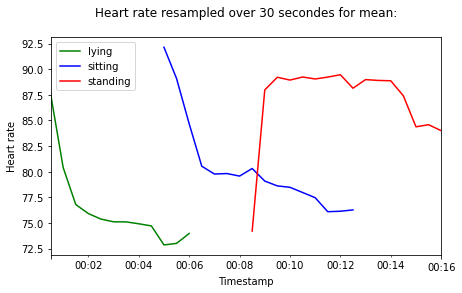

In [31]:
plt.figure(figsize=(7,4))
df_lying['heart rate'].resample('30s').mean().plot(color='green',label="lying")
df_sitting['heart rate'].resample('30s').mean().plot(color='blue',label="sitting")
df_standing['heart rate'].resample('30s').mean().plot(color='red',label="standing")
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Heart rate")
plt.title("Heart rate resampled over 30 secondes for mean:\n")
plt.show()

As we can see, as we expected in standing activity heart rate are increment over time not like lying and sitting activities, that heart rate coming down.

Now, we chose to represent three different activities to learn about the temperature according to each activity.


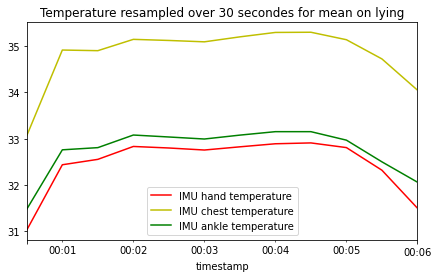

In [32]:
plt.figure(figsize=(7,4))
df_lying['IMU hand temperature'].resample('30s').mean().plot(color='r',legend=True)
df_lying['IMU chest temperature'].resample('30s').mean().plot(color='y',legend=True)
df_lying['IMU ankle temperature'].resample('30s').mean().plot(color='g',legend=True)
plt.title('Temperature resampled over 30 secondes for mean on lying')
plt.show() 

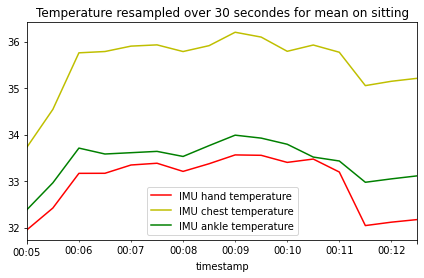

In [33]:
plt.figure(figsize=(7,4))
df_sitting['IMU hand temperature'].resample('30s').mean().plot(color='r',legend=True)
df_sitting['IMU chest temperature'].resample('30s').mean().plot(color='y',legend=True)
df_sitting['IMU ankle temperature'].resample('30s').mean().plot(color='g',legend=True)
plt.title('Temperature resampled over 30 secondes for mean on sitting')
plt.show()

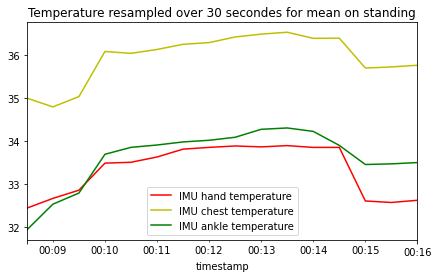

In [34]:
plt.figure(figsize=(7,4))
df_standing['IMU hand temperature'].resample('30s').mean().plot(color='r',legend=True)
df_standing['IMU chest temperature'].resample('30s').mean().plot(color='y',legend=True)
df_standing['IMU ankle temperature'].resample('30s').mean().plot(color='g',legend=True)
plt.title('Temperature resampled over 30 secondes for mean on standing')
plt.show()

**Our naive solution:**

We normalized all data between 0-1 to improve results.

In [35]:
def normalizeData(data):
  mean = np.mean(data).values[0]
  std = np.std(data).values[0]
  data = (data - mean)/std
  return data

#**KNN**

As a naive solution, we decide to use k nearest neighbors classifier, using only the most important columns to avoid long run time.

In [36]:
y_train = df_train['activityID']
x_train = df_train[naive_columns]
y_train = y_train.astype('int')

y_test = df_test['activityID']
x_test = df_test[naive_columns]

In [37]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [38]:
knn = KNeighborsClassifier(n_neighbors=5,metric='euclidean')
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [39]:
y_pred = knn.predict(x_test)

In [42]:
y_test = y_test.astype('int')

In [43]:
print('model accuracy on test set is: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))

model accuracy on test set is: 97.69%


#**Random Forest Classidfier**

Machine Learning - we choose to classify with Random Forest Classifier because this algorithm is fast we choose using all features.

In [44]:
print("Here we present how many records we have in train from each activity")
train_outcome = pd.crosstab(index=df_train["activityID"], columns="count") 
train_outcome

Here we present how many records we have in train from each activity


col_0,count
activityID,
1,72661
2,74586
3,67826


In [45]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [46]:
y_pred = rfc.predict(x_test)

In [47]:
y_pred

array([1, 1, 1, ..., 3, 3, 3])

In [48]:
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test,y_pred)*100))

model accuracy on test set is: 97.45616240336874%


In [49]:
cm = confusion_matrix(y_test, y_pred, normalize= 'true')

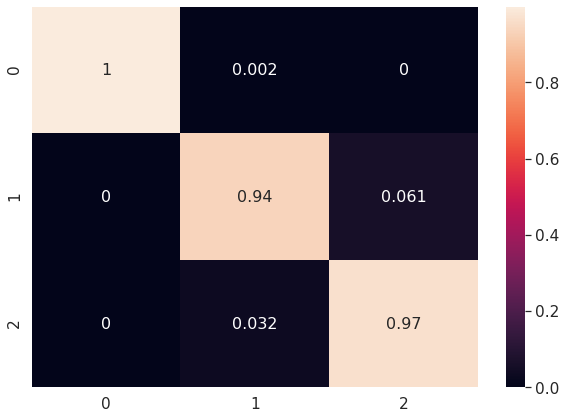

In [50]:
df_cm = pd.DataFrame(cm, range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

#**Voting Classifier with: KNN and Random Forest Classidfier**

In [61]:
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA

## Voting Hard

In [62]:
voting_hard = VotingClassifier(estimators=[('rfc', rfc), ('knn', knn)], voting='hard')
voting_hard.fit(x_train, y_train)
y_pred = voting_hard.predict(x_test)
print('Voting Hard accuracy on test set is: {}%'.format(accuracy_score(y_test,y_pred)*100))

Voting Hard accuracy on test set is: 97.51586952422852%


## Voting Soft


In [63]:
voting_soft = VotingClassifier(estimators=[('rfc', rfc), ('knn', knn)], voting='soft')
voting_soft.fit(x_train, y_train)
y_pred = voting_soft.predict(x_test)
print('Voting Soft accuracy on test set is: {}%'.format(accuracy_score(y_test,y_pred)*100))

Voting Soft accuracy on test set is: 97.51586952422852%


#**DecisionTree**

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(x_train, y_train)
y_pred = decisionTree.predict(x_test)
print('decisionTree accuracy on test set is: {}%'.format(accuracy_score(y_test,y_pred)*100))

decisionTree accuracy on test set is: 98.1097982527811%


#**AdaBoost**

In [72]:
from sklearn.ensemble import AdaBoostClassifier

In [73]:
adaBoost = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=200)
adaBoost.fit(x_train, y_train)
y_pred = adaBoost.predict(x_test)
print('AdaBoost accuracy on test set is: {}%'.format(accuracy_score(y_test,y_pred)*100))

AdaBoost accuracy on test set is: 98.1097982527811%
